# Agent Learning Using TD(0) 

Consider an agent **A** which is using MCTS and neural network *N* to find the
best move.

This algorithm works as follows: play *M* games, recording new state, previous state, the decision, expected reward and the reward after each move (in the expert memory).

In the training loop, sample *k* moves from the memory (experience replay), compute the loss between *N(s)* and expected reward and update the params of the network.

In [1]:
config = {
    "algorithm": "TD(0)",
    "network": "NonConvDenseOnly_v1",  # name of the network to use
    "name": "value-net-dense-v1",  # wandb run name
    
    # about MCTS
    "stochastic": False,  # the only option now is deterministic
    "time_limit": 1,
    "simuls_limit": 5,
    
    "seed": 0, # not used yet
    "optimizer": "Adam",  # not implemented yet
    # optimizer params...
    
    "test_seed": 42,  # used for always measuring performance on the same games
    "test_games": 10,
    "n_simulated_games": 5,
    "batch_size": 16,
    "n_training_loops": 20, # per one RL epoch
    "discount_factor": 0.95,
    "n_epochs": 50,
}

In [2]:
%load_ext autoreload
%autoreload 2

%pip install -Uq pip
%pip install install --quiet 'git+https://github.com/balgot/mathematico.git#egg=mathematico&subdirectory=game'
%pip install -q torch torchview torch-summary graphviz
%pip install -q tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import os, sys
sys.path.append(os.path.abspath(os.path.join("../")))

import mathematico
from src.utils import mcts
from agent import MathematicoState, MctsPlayer  # TODO: import regular agent from src/agents/...

import random
import statistics

from tqdm.notebook import trange, tqdm

# check if cuda is available
# dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# dev

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Neural Network Definition

As the input, the network takes `list[list[int]]` - the board and the card number of type `int`, and it approximates the value function `V(s) = V((board, card))`.

All inputs are one-hot encoded.

/home/miso/fi/uiprojekt/venv/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


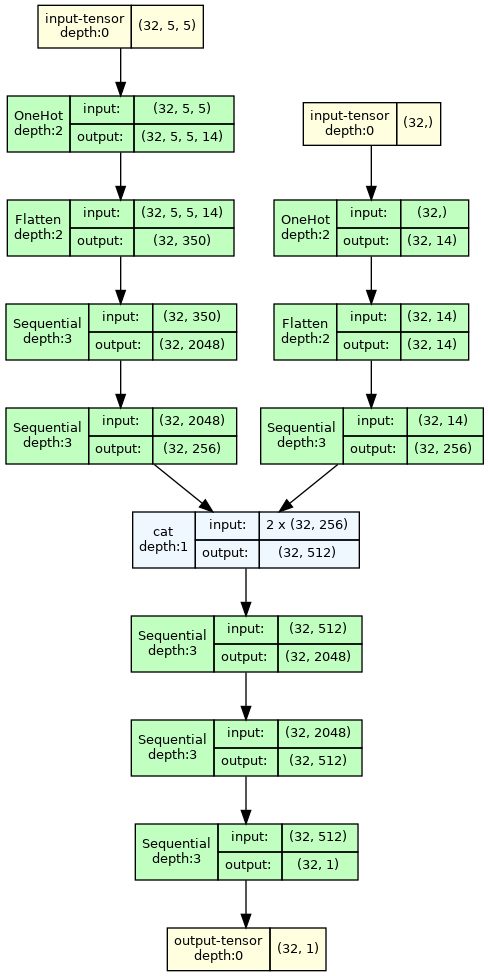

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256]                 --
|    └─OneHot: 2-1                       [-1, 1, 5, 5, 14]         --
|    └─Flatten: 2-2                      [-1, 350]                 --
|    └─DenseBlock: 2-3                   [-1, 2048]                --
|    |    └─Sequential: 3-1              [-1, 2048]                2,808,320
|    └─DenseBlock: 2-4                   [-1, 256]                 --
|    |    └─Sequential: 3-2              [-1, 256]                 2,754,816
├─Sequential: 1-2                        [-1, 256]                 --
|    └─OneHot: 2-5                       [-1, 1, 14]               --
|    └─Flatten: 2-6                      [-1, 14]                  --
|    └─DenseBlock: 2-7                   [-1, 256]                 --
|    |    └─Sequential: 3-3              [-1, 256]                 42,816
├─Sequential: 1-3                        [-1, 1]                   

In [4]:
from torchview import draw_graph
# VS code fix for cropped images from torchview
import graphviz
graphviz.set_jupyter_format('png')
from torchsummary import summary

# create the network
import src.nets as nets
_nn_cls = getattr(nets, config["network"])
model = _nn_cls()  # .to(dev)

# create the optimizer
optimizer = torch.optim.Adam(model.parameters())

# create fake input for testing the net and displaying the info
_board = [[0, 1, 11, 12, 13]] * 5  # 5x5 board of ints
_card = 13
_batch_size = 32
_board_batch = torch.tensor([_board] * _batch_size)
_card_batch = torch.tensor([_card] * _batch_size)

# run the network to check it works
model.forward(_board_batch, _card_batch)

# display the model architecture
display(draw_graph(model, input_data=(_board_batch, _card_batch), depth=3).visual_graph)

# get the summary of the model
summary(model, [(1, 5, 5), (1, )]);

### Weight & Biases Initialisation

In [18]:
%pip install -q wandb
import wandb
wandb.init(config=config, project="PA026", name=config.get("name", None))

Note: you may need to restart the kernel to use updated packages.


### Agent

In [6]:
def policy(state: MathematicoState) -> float:
    board = torch.tensor([state.board.grid])
    card = torch.tensor([state.number])
    return model(board, card)


agent = MctsPlayer(config["time_limit"], max_iters=config["simuls_limit"], policy=policy)

In [7]:
%%time

# check it works by playing a random game
random.seed(0)
arena = mathematico.Arena()
arena.add_player(agent)
arena.run(seed=0, rounds=3, verbose=True)

Steps run: 3	Elapsed time: 0.5549204349517822
CPU times: user 2.19 s, sys: 0 ns, total: 2.19 s
Wall time: 556 ms


[[130, 90, 90]]

### TD(0)

#### Utils

In [20]:
from copy import deepcopy

def _test_performance(agent, model, rounds, verbose=False):
    model.eval()

    # exactly same implementation of arena but with tqdm and different seeds
    class _Arena(mathematico.Arena):
        def run(self, rounds, seed = 0):
            for i in trange(rounds, desc="Testing", leave=None, position=1):
                game = mathematico.Mathematico(seed=seed + i)
                for player in self.players:
                    player.reset()
                    game.add_player(player)

                results = game.play(verbose=False)
                for idx, result in enumerate(results):
                    self.results[idx].append(result)
            return self.results


    arena = _Arena()
    arena.add_player(agent)
    results = arena.run(rounds=rounds, seed=config.get("test_seed", 0))

    # get the results
    results = results[0]
    
    # get the mean and stddev
    mean = statistics.mean(results)
    std = statistics.stdev(results)
    if verbose:
        print(f"{results=}")
        print(f"{mean=}\t{std=}")

    return mean, std


def learn_episode(agent: MctsPlayer, model: nn.Module, n_games, batch_size, m_training, gamma):
    expert_memory = []  # could have global memory accross different epochs, at least for the late-game states

    # playing phase
    model.eval()
    for game in trange(n_games, desc="Game playing phase", leave=None, position=1):
        # initialize the game
        agent.reset()
        cards = [i for i in range(1, 13+1) for _ in range(4)]
        random.shuffle(cards)

        # game memory
        states = []  # board, card pairs
        estimates = []
        rewards = []  # either next state estimate or the actual reward

        # play all the moves till the end
        for move in trange(5*5, desc="Playing moves", leave=None, position=2):
            state = deepcopy(agent.board.grid)
            card = cards[move]
            action, estimate = agent.best_move(card)
            states.append((state, card))
            estimates.append(estimate)

            if move != 0:
                rewards.append(gamma * estimate)
            
            agent.play_move(action, card)

        rewards.append(agent.board.score())

        # TODO?: propagate reward backwards
        # for i in reversed(range(len(rewards) - 1)):
        #    rewards[i] += gamma * rewards[i+1]

        for s, e, r in zip(states, estimates, rewards):
            expert_memory.append((s, e, r))

    # learning phase, TODO: some random symmetries apply
    model.train()
    for train in trange(m_training, desc="Training loop", leave=None, position=1):
        batch = random.sample(expert_memory, batch_size)
        boards = []
        cards = []
        outs = []
        targets = []

        for s, e, r in batch:
            boards.append(s[0])
            cards.append(s[1])
            outs.append(e)
            targets.append(r)

        optimizer.zero_grad()
        _outputs = model(torch.tensor(boards), torch.tensor(cards))
        loss = torch.sum((_outputs - torch.tensor(targets)) ** 2)
        loss.backward()
        optimizer.step()


#### One Round

In [21]:
%%time

print("Performance before the training:")
mean, stdev = _test_performance(agent, model, verbose=True, rounds=config["test_games"])
wandb.log({"Mean": mean, "Stdev": stdev})

learn_episode(
    agent, 
    model, 
    n_games=config["n_simulated_games"], 
    batch_size=config["batch_size"], 
    m_training=config["n_training_loops"], 
    gamma=config["discount_factor"]
)

print("Performance after training one episode:")
mean, stdev = _test_performance(agent, model, verbose=True, rounds=config["test_games"])
wandb.log({"Mean": mean, "Stdev": stdev})

Performance before the training:


Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[130, 140, 90, 130, 100, 140, 30, 100, 50, 40]
mean=95	std=41.96559437338057


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Performance after training one episode:


Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[110, 90, 90, 120, 80, 130, 60, 110, 120, 70]
mean=98	std=23.475755815545345
CPU times: user 26 s, sys: 1.06 s, total: 27 s
Wall time: 6.84 s


#### Multiple Rounds

In [22]:
%%time

for epoch in trange(config["n_epochs"], desc="Epochs", leave=None):
    learn_episode(
        agent, 
        model, 
        n_games=config["n_simulated_games"], 
        batch_size=config["batch_size"], 
        m_training=config["n_training_loops"], 
        gamma=config["discount_factor"]
    )
    
    mean, stdev = _test_performance(agent, model, verbose=True, rounds=config["test_games"])
    wandb.log({"Mean": mean, "Stdev": stdev})

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[80, 80, 150, 70, 80, 110, 100, 50, 120, 110]
mean=95	std=28.771127502720116


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[100, 40, 90, 80, 40, 90, 80, 80, 60, 80]
mean=74	std=20.65591117977289


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[110, 70, 180, 100, 70, 100, 50, 70, 120, 80]
mean=95	std=36.89323936863109


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[80, 100, 100, 60, 70, 110, 90, 100, 150, 80]
mean=94	std=25.03331114069145


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[80, 70, 90, 90, 60, 90, 60, 90, 100, 90]
mean=82	std=13.98411797560202


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[80, 80, 80, 60, 60, 100, 90, 70, 110, 70]
mean=80	std=16.32993161855452


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[100, 130, 100, 50, 30, 90, 90, 80, 100, 40]
mean=81	std=31.42893217686178


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[110, 40, 100, 90, 80, 60, 60, 60, 80, 60]
mean=74	std=21.70509412813294


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[70, 80, 90, 80, 40, 80, 40, 80, 70, 80]
mean=71	std=17.28840330651992


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[80, 90, 60, 70, 90, 60, 60, 100, 70, 90]
mean=77	std=14.944341180973263


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[90, 70, 90, 60, 90, 100, 70, 30, 120, 60]
mean=78	std=25.298221281347036


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[100, 70, 100, 120, 50, 80, 80, 50, 50, 60]
mean=76	std=24.585451886114367


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[120, 60, 110, 160, 50, 140, 80, 80, 60, 100]
mean=96	std=36.575644598253874


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[90, 120, 60, 80, 80, 80, 70, 100, 90, 40]
mean=81	std=21.83269719175042


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[70, 90, 50, 70, 90, 120, 110, 60, 70, 60]
mean=79	std=22.82785822435191


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[70, 130, 110, 80, 100, 150, 90, 110, 90, 110]
mean=104	std=23.664319132398465


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[100, 30, 130, 80, 110, 90, 70, 70, 110, 140]
mean=93	std=32.33505150074073


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[130, 90, 90, 40, 50, 70, 110, 70, 90, 30]
mean=77	std=31.287200080686173


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[90, 50, 130, 130, 80, 120, 100, 100, 90, 80]
mean=97	std=24.96664441476534


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[90, 60, 40, 130, 20, 130, 90, 90, 110, 70]
mean=83	std=36.224607965059086


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[80, 40, 60, 100, 70, 140, 20, 50, 190, 90]
mean=84	std=50.15531433014407


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[110, 50, 70, 90, 60, 130, 120, 50, 100, 100]
mean=88	std=28.982753492378876


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[80, 70, 60, 100, 100, 90, 70, 60, 90, 70]
mean=79	std=15.238839267549947


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[60, 70, 160, 70, 70, 140, 110, 70, 80, 120]
mean=95	std=35.039660069381064


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[100, 40, 100, 80, 30, 280, 40, 50, 80, 80]
mean=88	std=72.08020224413605


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[110, 70, 60, 100, 40, 190, 70, 50, 70, 90]
mean=85	std=42.7525177946022


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[70, 140, 120, 100, 90, 80, 100, 90, 90, 80]
mean=96	std=20.65591117977289


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[150, 100, 110, 80, 50, 80, 80, 70, 80, 90]
mean=89	std=26.853512081497108


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[100, 90, 60, 220, 120, 80, 130, 0, 100, 100]
mean=100	std=55.57777333511022


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[110, 40, 70, 140, 80, 90, 50, 90, 60, 70]
mean=80	std=29.43920288775949


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[110, 110, 100, 60, 70, 160, 70, 70, 90, 50]
mean=89	std=32.47221034122014


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[140, 100, 90, 110, 90, 130, 70, 80, 150, 60]
mean=102	std=30.11090610836324


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[90, 100, 90, 100, 80, 140, 110, 70, 80, 110]
mean=97	std=20.027758514399736


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[70, 50, 70, 60, 40, 70, 60, 100, 70, 60]
mean=65	std=15.811388300841896


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[110, 90, 130, 90, 110, 150, 90, 110, 110, 80]
mean=107	std=21.10818693198342


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[100, 70, 130, 90, 80, 150, 100, 80, 40, 80]
mean=92	std=30.840089349921005


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[90, 50, 120, 50, 100, 120, 80, 110, 100, 80]
mean=90	std=25.385910352879694


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[70, 90, 100, 80, 50, 210, 70, 110, 140, 90]
mean=101	std=45.570458267024996


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[70, 80, 90, 100, 100, 70, 80, 100, 80, 110]
mean=88	std=13.98411797560202


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[100, 120, 90, 110, 90, 100, 100, 70, 70, 40]
mean=89	std=23.309511649396118


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[30, 60, 110, 100, 70, 180, 80, 60, 130, 110]
mean=93	std=42.70050741306634


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[90, 80, 170, 110, 100, 60, 100, 110, 60, 100]
mean=98	std=31.198290551460243


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[110, 130, 140, 90, 90, 140, 80, 50, 50, 100]
mean=98	std=32.93090409394258


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[80, 80, 130, 50, 80, 100, 30, 60, 50, 60]
mean=72	std=28.596814119369622


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[80, 90, 100, 80, 30, 120, 70, 100, 30, 80]
mean=78	std=28.982753492378876


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[100, 110, 100, 70, 40, 130, 50, 70, 60, 50]
mean=78	std=30.11090610836324


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[40, 70, 150, 70, 80, 70, 100, 40, 90, 60]
mean=77	std=31.989581637360207


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[80, 110, 150, 50, 90, 140, 50, 100, 90, 50]
mean=91	std=35.73047252229764


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[90, 40, 110, 100, 90, 130, 120, 50, 70, 60]
mean=86	std=30.258148581093913


Game playing phase:   0%|          | 0/5 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Playing moves:   0%|          | 0/25 [00:00<?, ?it/s]

Training loop:   0%|          | 0/20 [00:00<?, ?it/s]

Testing:   0%|          | 0/10 [00:00<?, ?it/s]

results=[100, 50, 130, 60, 70, 70, 70, 140, 90, 40]
mean=82	std=32.93090409394258
CPU times: user 15min 57s, sys: 30.1 s, total: 16min 27s
Wall time: 4min 10s


In [23]:
wandb.finish()

Mean,▄▆▇▃▆▆▃▄▃▃▃▃▄▃▇▃▆▄▅▃▆▄▆▅▃▅▇▁█▅▇▅▅▇▇▂▃▃▅▄
Stdev,▄▇▃▂▆▃▂▅▃▁▄▃▃▃▃▅▃▆▄▁▆▇▂▄▄▅▅▁▃▅█▁▃▅▅▄▅▅▆▅
Mean,82
Stdev,32.9309
